Import all the libraries needed.

In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST, FashionMNIST, ImageFolder
import torchvision.transforms as transforms
# from torchvision.transforms import ToTensor, Compose, Resize
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


We create a transform to resize the image and convert it to a tensor.

In [24]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
# composed = Compose([Resize((IMAGE_SIZE, IMAGE_SIZE)), ToTensor()])

Loading the training dataset. We can load the training dataset by setting train=True.

In [25]:
# dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
train_dataset = FashionMNIST(root='data/',train=True, download=True, transform=composed)

Let us evaluate the number of images present in the training dataset.

In [26]:
len(train_dataset)

60000

Download validation set by turning train=False

In [27]:
test_dataset = FashionMNIST(root='data/', train=False, download=True, transform=composed)

Let us see the number of samples present in the test dataset.

In [28]:
len(test_dataset)

10000

Show the label for the first element in the training dataset.

In [29]:


train_dataset[0][1]

9

Created a function to show the images.

In [30]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

Let us see select any random image. For example let us see how the sixth image of the training dataset looks like.

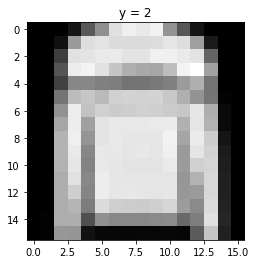

In [31]:

show_data(train_dataset[5])

We see that the images are of very low resolution. This will result in fewer parameters and will help in training the model faster. Correspondinly, let us try to visualize the fourth element from the test dataset.

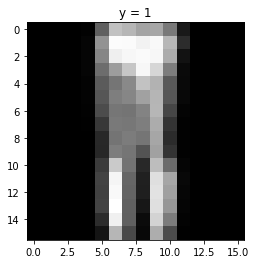

In [32]:
show_data(test_dataset[3])

Now, let's try to see how the image and the label tensors look like.

In [33]:
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([1, 16, 16]) 9


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0431, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0235,
          0.2588, 0.4039, 0.2000, 0.0549, 0.0039, 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0863,
          0.6039, 0.7451, 0.5569, 0.4314, 0.2353, 0.1529, 0.2588, 0.1451],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.3098,
          0.8039, 0.8706, 0.8039, 0.6863, 0.5843, 0.5059, 0.5725, 0.3961],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4510,
          0.8588, 0.8667, 0.8588, 0.8588, 0.8392, 0.8000, 0.8510, 0.3686],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0235, 0.5373,
          0.8588, 0.8275, 0.7529

Model Building using Convolutional Neural Network.

After doing an initial exploratory analysis on the data, let us build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [34]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
    # Outputs in each steps
    def activations(self, x):
        
        z1 = self.cnn1(x)
        a1 = self.relu1(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = self.relu2(z2)
        out = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out

In [35]:
model = CNN(out_1=16, out_2=32)

Now let us define the loss function, optimizer and dataset loader.

In [36]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000)

Set all the hyperparameters and start training the model.

In [37]:
n_epochs= 10
loss_list=[]
accuracy_list=[]
N_test=len(test_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in test_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        loss_list.append(loss.data)
train_model(n_epochs)

Let us analyse the loss values so far.

In [38]:
loss_list

[tensor(0.4581),
 tensor(0.3544),
 tensor(0.3096),
 tensor(0.2822),
 tensor(0.2704),
 tensor(0.2558),
 tensor(0.2438),
 tensor(0.2363),
 tensor(0.2318),
 tensor(0.2259)]

The final loss after the model completes all the epochs.

In [39]:
final_loss = loss_list[-1]
final_loss

tensor(0.2259)

Similarly, let us analyze the list of accuracy values.

In [40]:
accuracy_list

[0.8057, 0.8366, 0.8483, 0.8577, 0.8641, 0.8693, 0.8737, 0.8773, 0.8798, 0.882]

See the final accuracy of the trained model.

In [41]:
final_accuracy = accuracy_list[-1]
final_accuracy

0.882

As we can see, the model achieved a decent accuracy score of 86% using a simple CNN architecture. Here's a plot showing how the model accuracy improves as it is trained for more number of epochs.

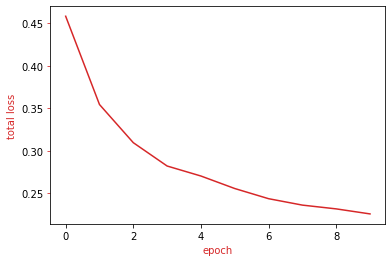

In [42]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    


We see that the loss has almost flattened out by the end of 10 epochs and continues to decrease very gradually.